## Exploratory Data Analysis

In [3]:
# Load the libraries
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(httr)

## Source
This data is from [UCI repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

    Abstract: This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.

The dataset has 17839 instances and 16 attributes and no NA values, seperated in two csv files: `hour.csv` and `day.csv`. The following are list of attributes and their meanings:
 - instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

**Note**: The attribute `hr` is **not** included in `day.csv`

## Reading the data

In [7]:
# Downloads zip to tempfile
BIKE_URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
GET(BIKE_URL, write_disk(tf <- tempfile(fileext = ".zip")))
# Unzip tempfile and disgards the hourly data and use daily only
bike_sharing_day <- read_csv(unz(tf, "day.csv"))
# Unlink/remove the temporary file
unlink(tf)
head(bike_sharing_day)


Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip]
  Date: 2022-11-01 19:44
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 280 kB
<ON DISK>  C:\Users\chunq\AppData\Local\Temp\Rtmpqc53fV\file4168412352d9.zipNULL

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


In [10]:
summary(bike_sharing_day)

    instant          dteday               season            yr        
 Min.   :  1.0   Min.   :2011-01-01   Min.   :1.000   Min.   :0.0000  
 1st Qu.:183.5   1st Qu.:2011-07-02   1st Qu.:2.000   1st Qu.:0.0000  
 Median :366.0   Median :2012-01-01   Median :3.000   Median :1.0000  
 Mean   :366.0   Mean   :2012-01-01   Mean   :2.497   Mean   :0.5007  
 3rd Qu.:548.5   3rd Qu.:2012-07-01   3rd Qu.:3.000   3rd Qu.:1.0000  
 Max.   :731.0   Max.   :2012-12-31   Max.   :4.000   Max.   :1.0000  
      mnth          holiday           weekday        workingday   
 Min.   : 1.00   Min.   :0.00000   Min.   :0.000   Min.   :0.000  
 1st Qu.: 4.00   1st Qu.:0.00000   1st Qu.:1.000   1st Qu.:0.000  
 Median : 7.00   Median :0.00000   Median :3.000   Median :1.000  
 Mean   : 6.52   Mean   :0.02873   Mean   :2.997   Mean   :0.684  
 3rd Qu.:10.00   3rd Qu.:0.00000   3rd Qu.:5.000   3rd Qu.:1.000  
 Max.   :12.00   Max.   :1.00000   Max.   :6.000   Max.   :1.000  
   weathersit         temp        

We noticed `temp`, `atemp`, `hum`, `windspeed` are all "normalized" variables given from the originial dataset description according to some transformations. Moreover, we have some time variables like: `year`, `mnth`, `dteday`, whereas we are going to discard these for easiness of modelling and not consider it at all when selecting variables. Also, according to the original dataset, we know that `cnt` =  `casual` + `registered`, hence this could likely cause collinearity problem later, hence we would only focus on `cnt` as a response variable. Also, similar variables like `holiday`, `workingday` might have similar issue, hence we would keep one of the two.

Now, we are going to plot some scatterplots of possible explanators agains the response `cnt`, and the sample distribution of these variables. Before that, we are wrangling our data by excluding irrevelant variables and apply suitable transformations.

In [26]:
# Wrangling data
# Selecting relevant/meaningful columns
# Transform categorical variables to factors
bike_wrangled <- bike_sharing_day %>%
                 select(yr, workingday:windspeed, cnt) %>%
                 mutate(across(yr:weathersit, as.factor))
head(bike_wrangled)

yr,workingday,weathersit,temp,atemp,hum,windspeed,cnt
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,2,0.344167,0.363625,0.805833,0.1604460,985
0,0,2,0.363478,0.353739,0.696087,0.2485390,801
0,1,1,0.196364,0.189405,0.437273,0.2483090,1349
0,1,1,0.200000,0.212122,0.590435,0.1602960,1562
0,1,1,0.226957,0.229270,0.436957,0.1869000,1600
0,1,1,0.204348,0.233209,0.518261,0.0895652,1606


In [32]:
# Use this cell to adjust the plot size
options(repr.plot.width = 15, repr.plot.height = 15)

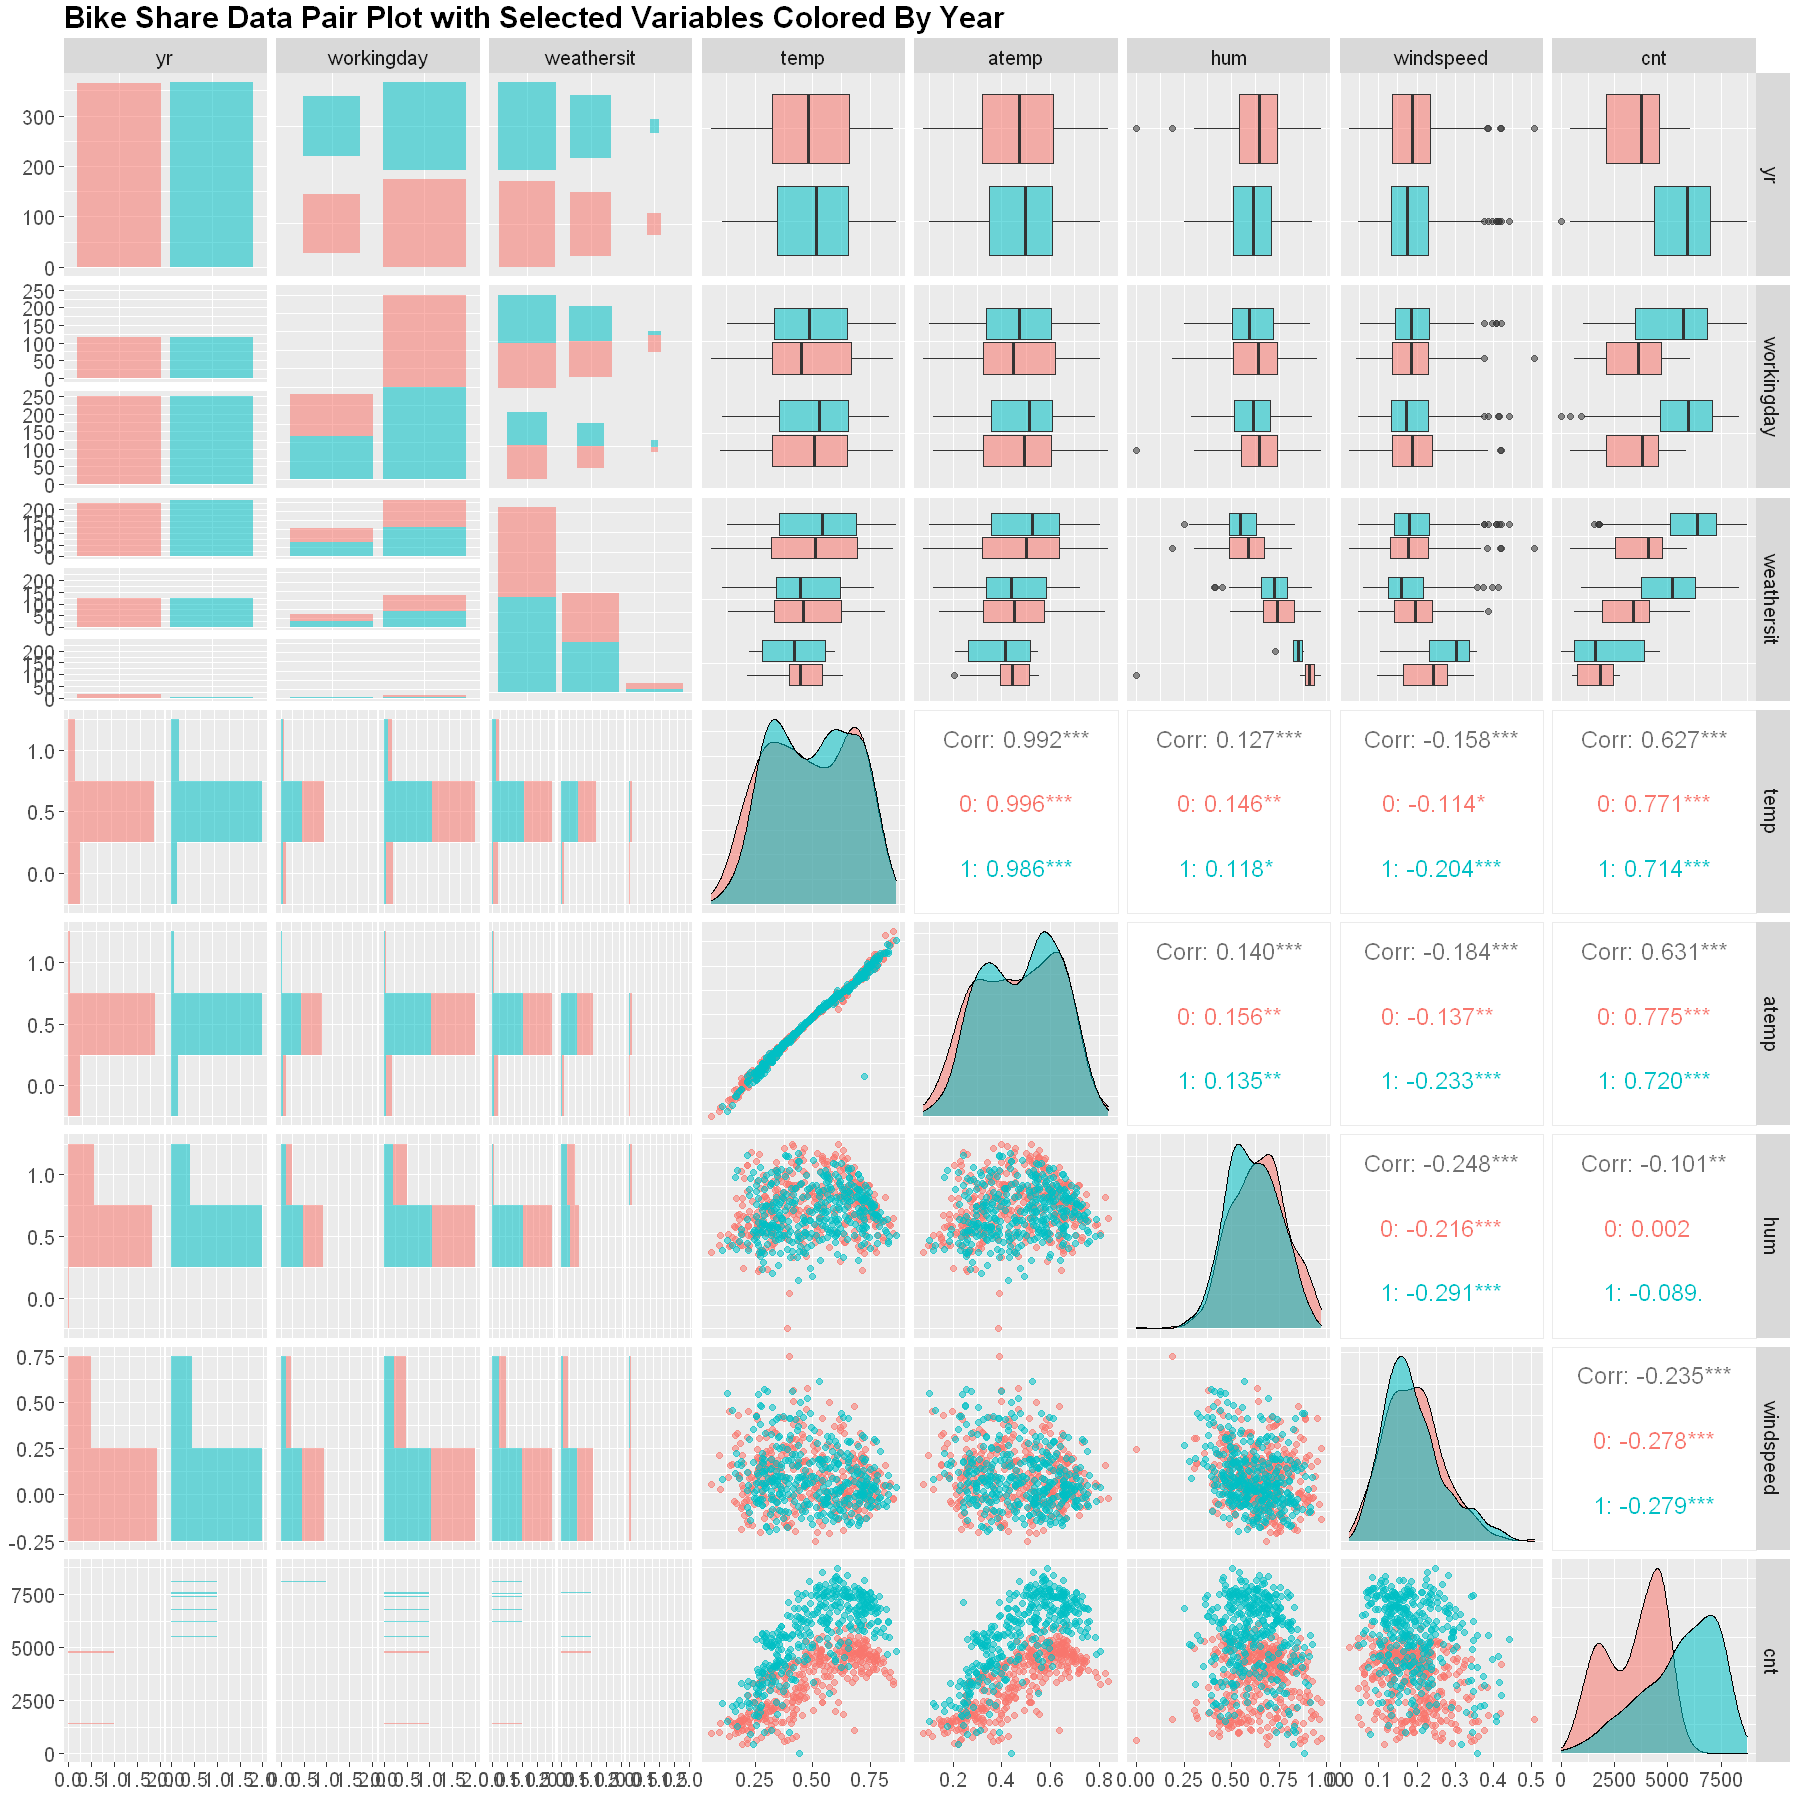

In [35]:
# Visualize the association between our variable of interest (season, workingday, weathersit, 
# temp, atemp, hum, windspeed, cnt)
bs_day_pair_plots <- bike_wrangled %>%
    ggpairs(progress = FALSE,
         mapping = aes(color=yr, alpha=0.4),
         lower=list(combo=wrap("facethist", binwidth=0.5)),
         upper=list(continuous = wrap("cor", size=5))) +
    ggtitle("Bike Share Data Pair Plot with Selected Variables Colored By Year") +
    theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
    )
bs_day_pair_plots

**Note**: the red = 0, corresponds to 2010, the blue = 1, corresponds to 2011

## CHECK THIS BELOW!!!!

In [23]:
# Dummy model
mod <- lm(cnt ~ temp + atemp + hum + windspeed, data = train)
# Calculate rmse
rmse <- function(preds, actual){
    sqrt(mean(preds - actual)^2)
}

#Obtain the estimated coefficients, their standard errors, corresponding  p-values using tidy()
tidy(mod) %>% mutate_if(is.numeric, round, 2)

# Predictions are using model fitted with train to predict on test
# VS
# Actuals, the response variable column in the test data
rmse(preds = predict(mod, newdata = test), actual = test$cnt) 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2960.13,359.92,8.22,0.00
temp,-6806.27,3519.60,-1.93,0.05
atemp,14750.10,3958.63,3.73,0.00
hum,-3160.42,359.40,-8.79,0.00
windspeed,-2745.66,721.54,-3.81,0.00


[1] 1704.072

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


`geom_smooth()` using formula 'y ~ x'

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`geom_smooth()` using formula 'y ~ x'

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



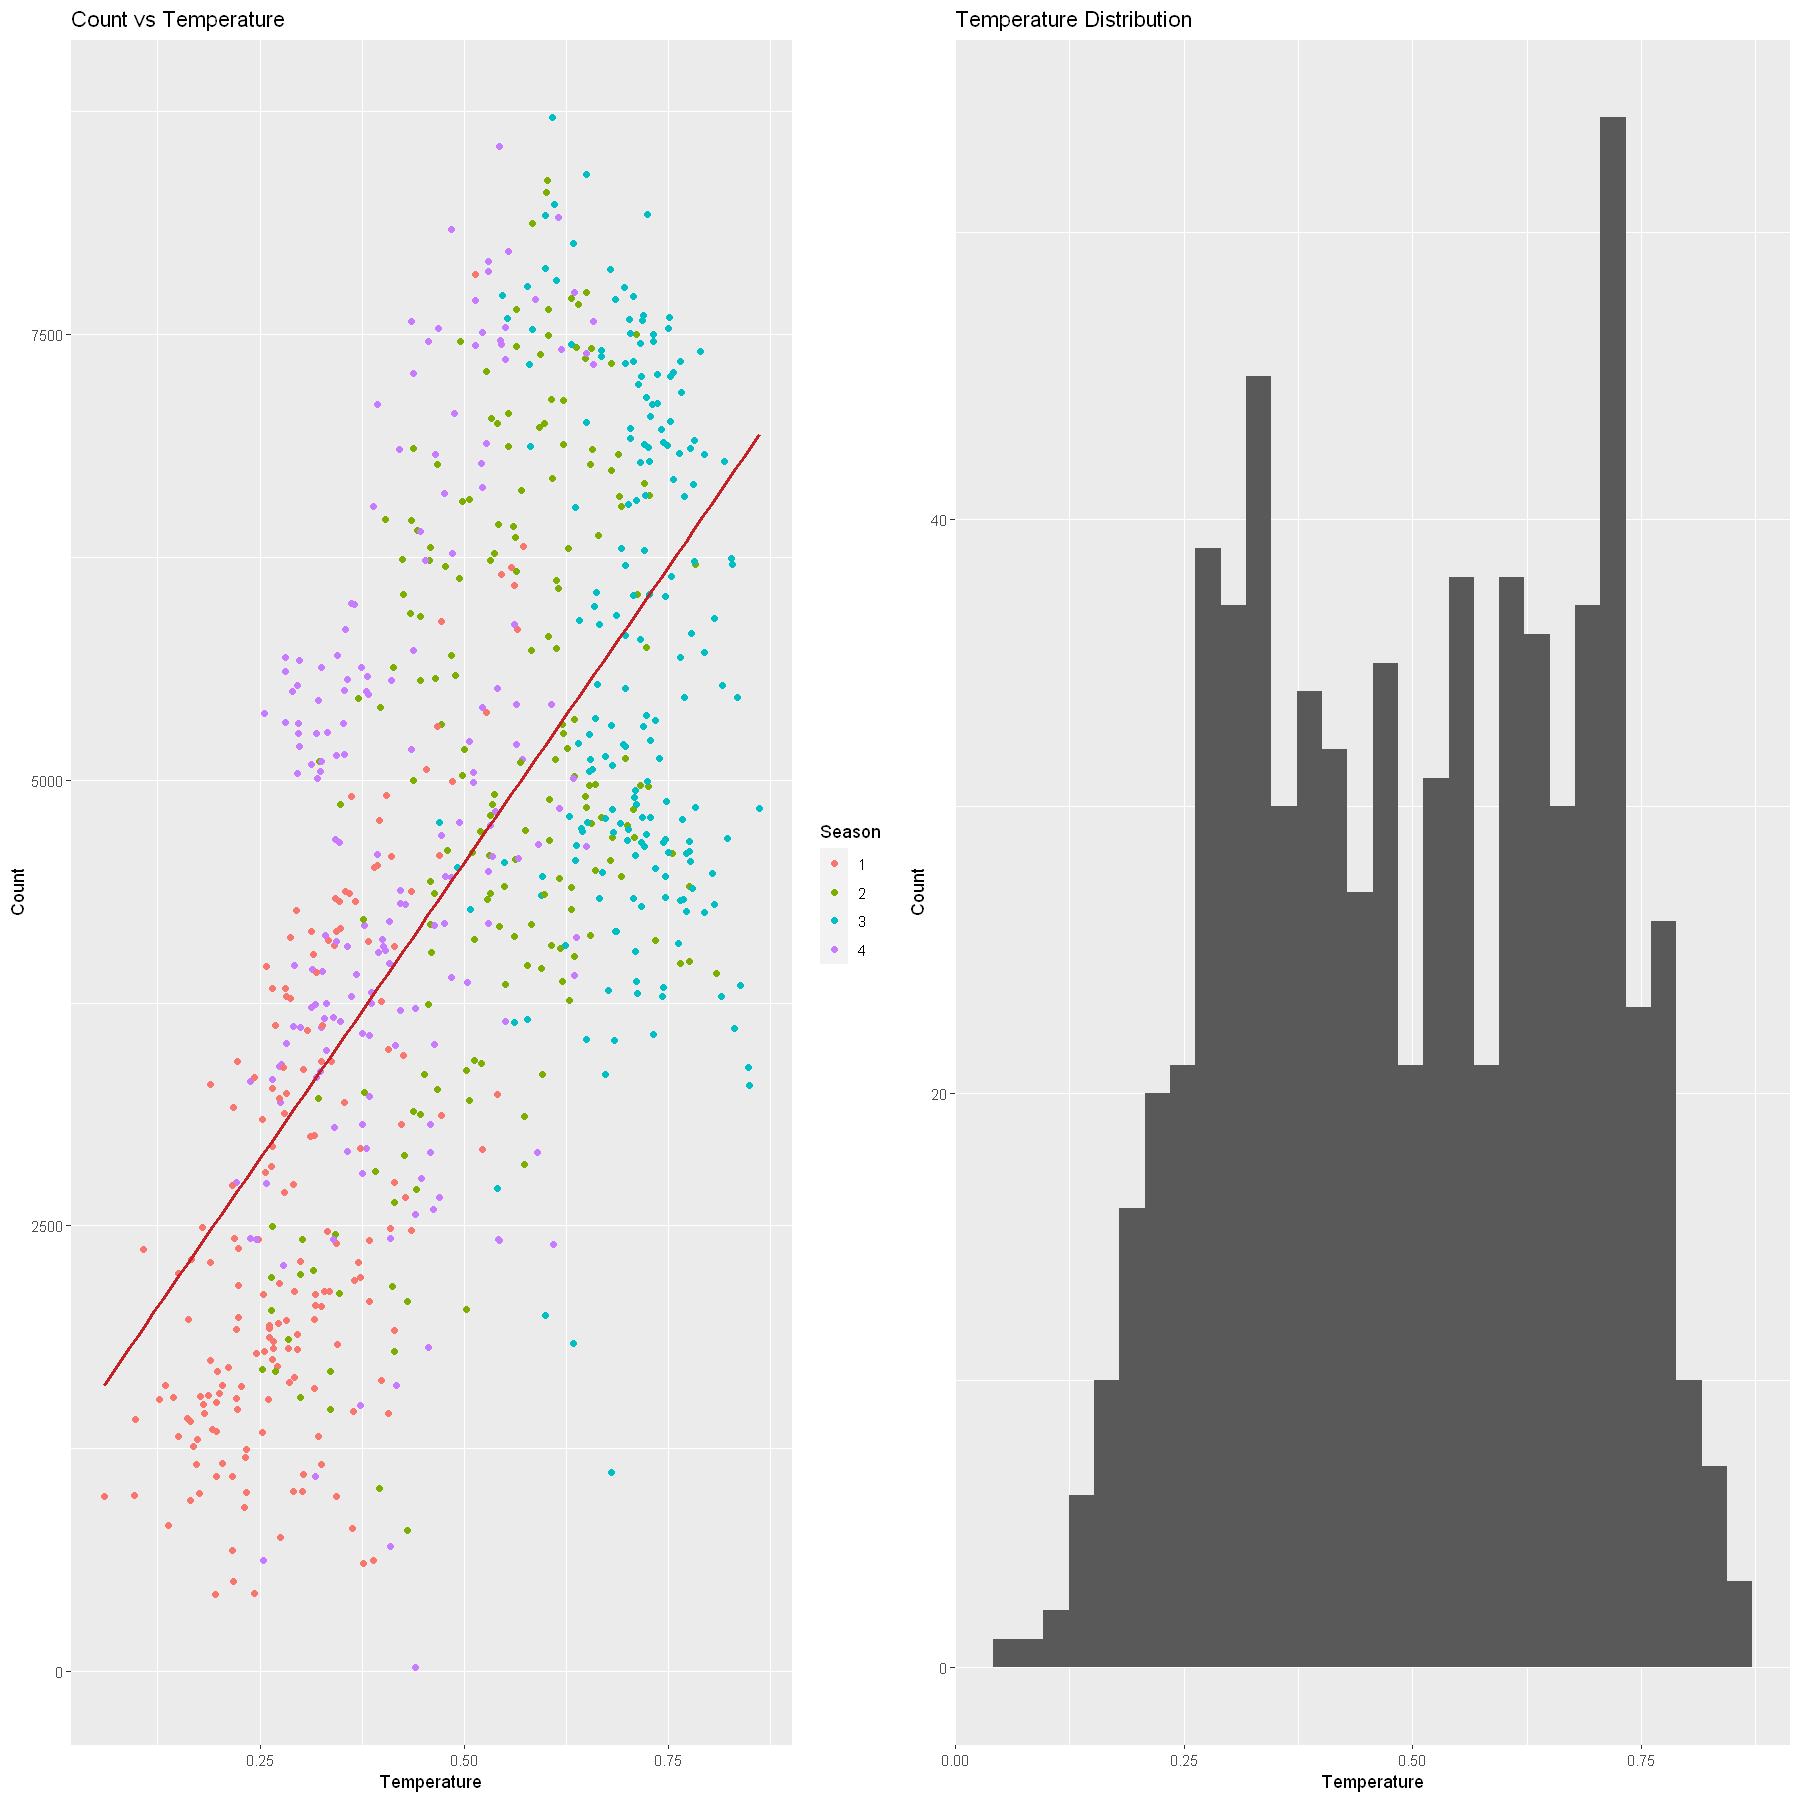

`geom_smooth()` using formula 'y ~ x'

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



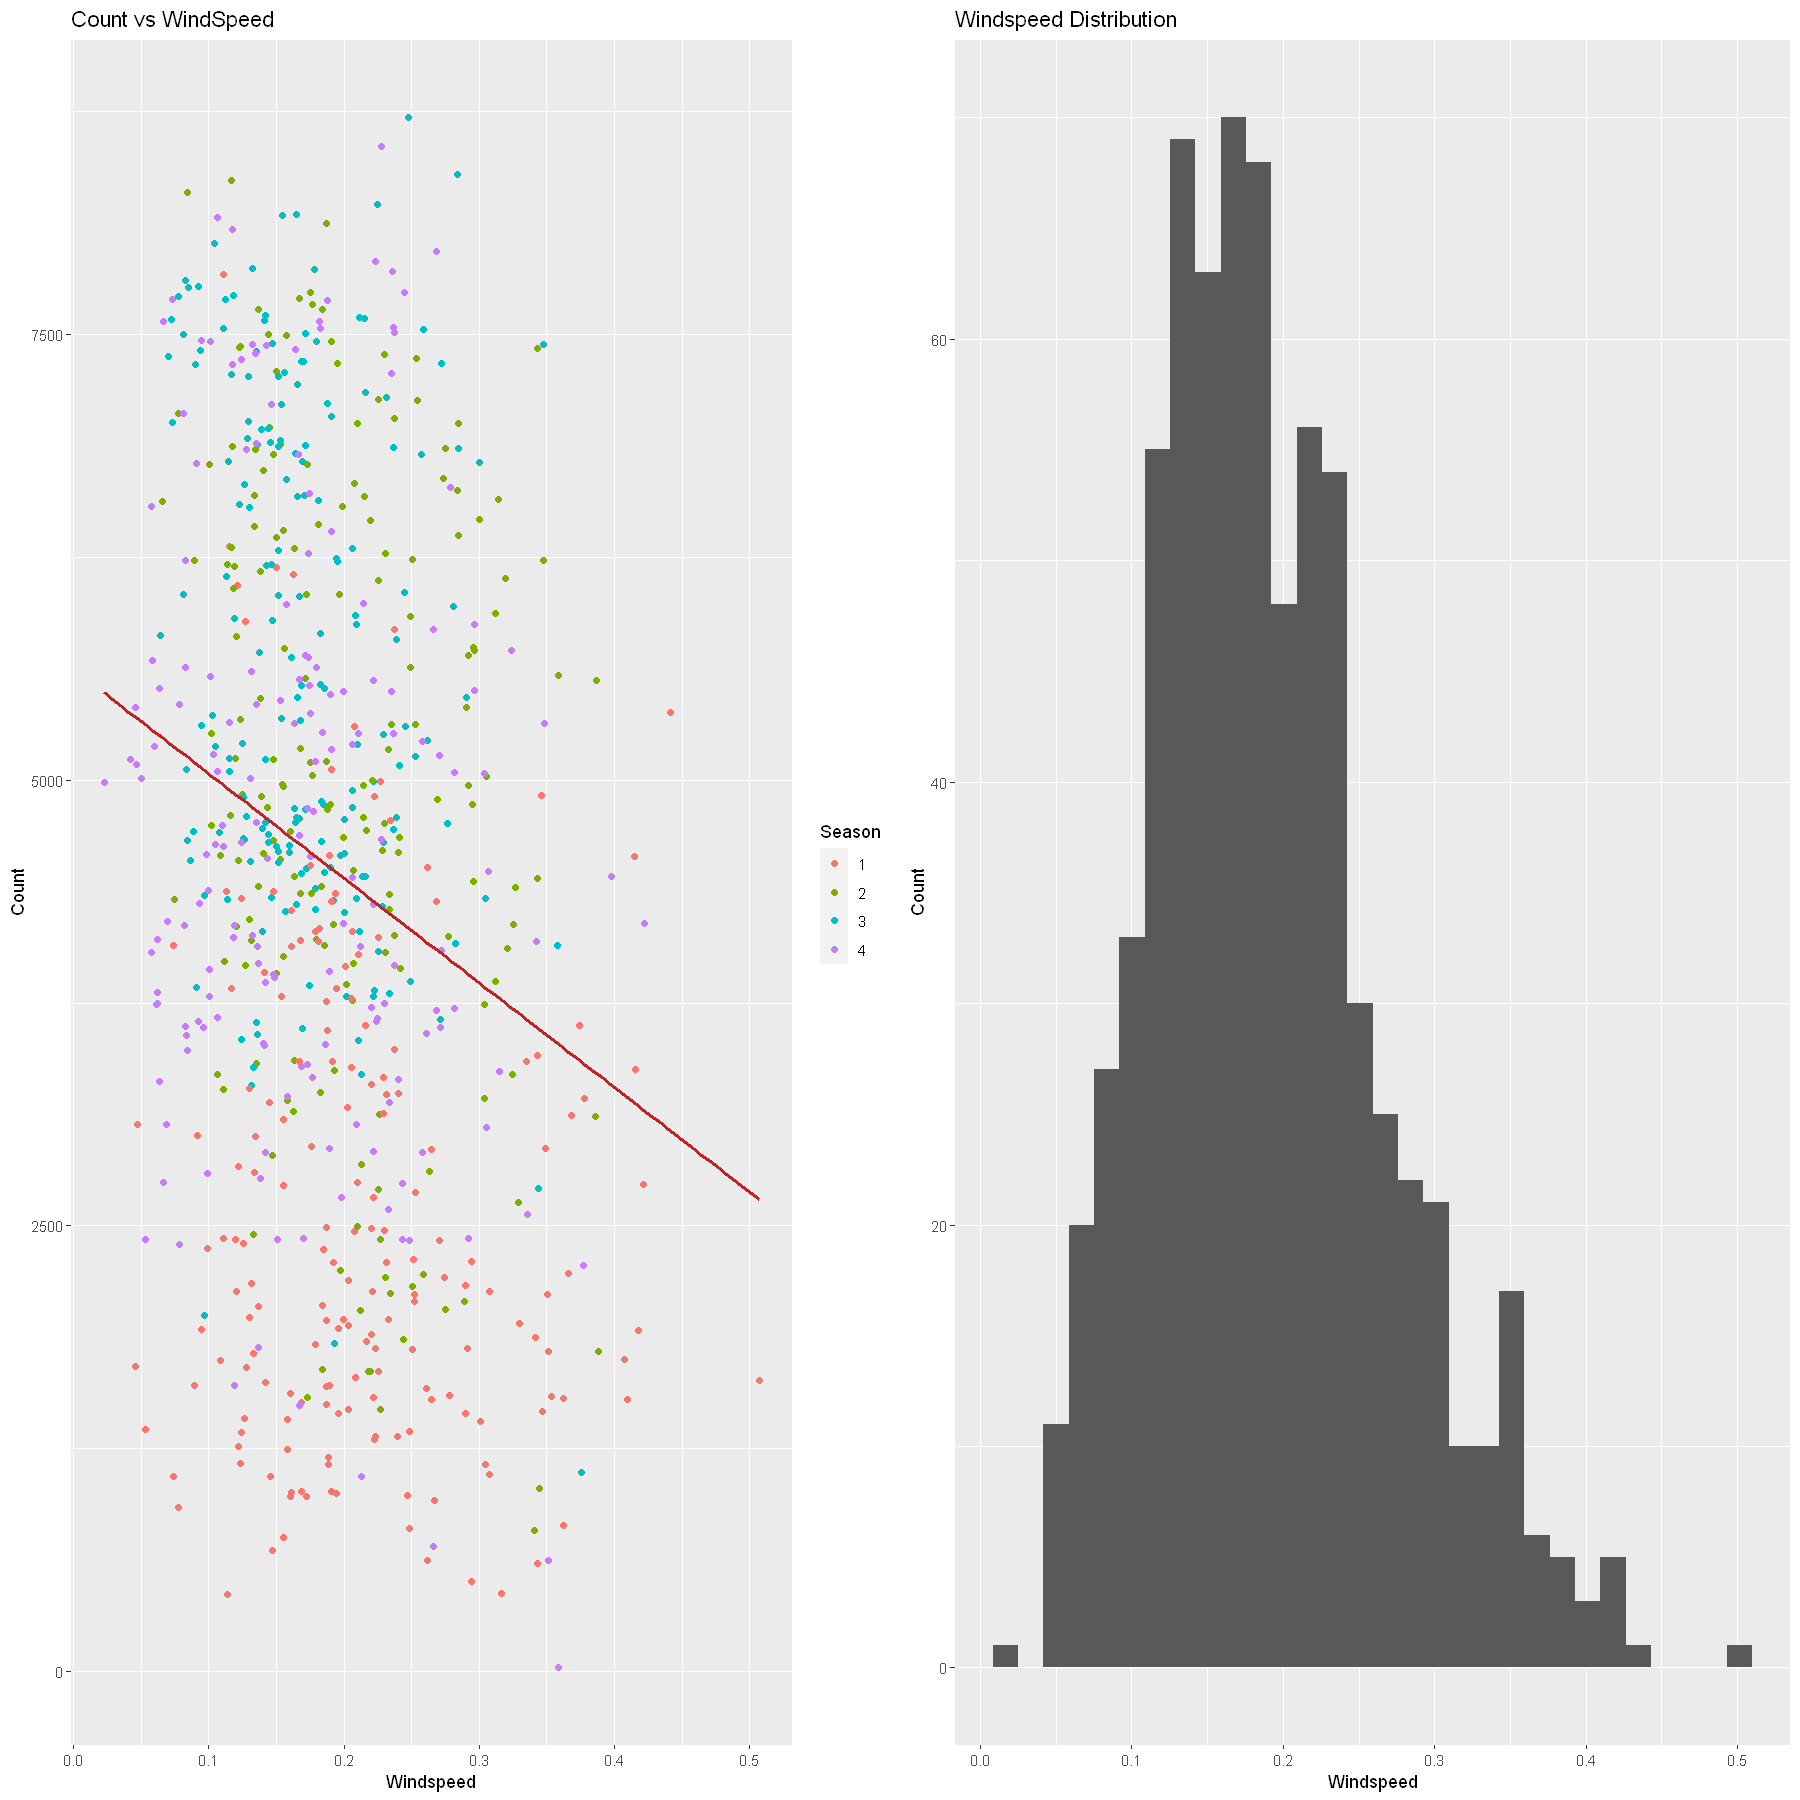

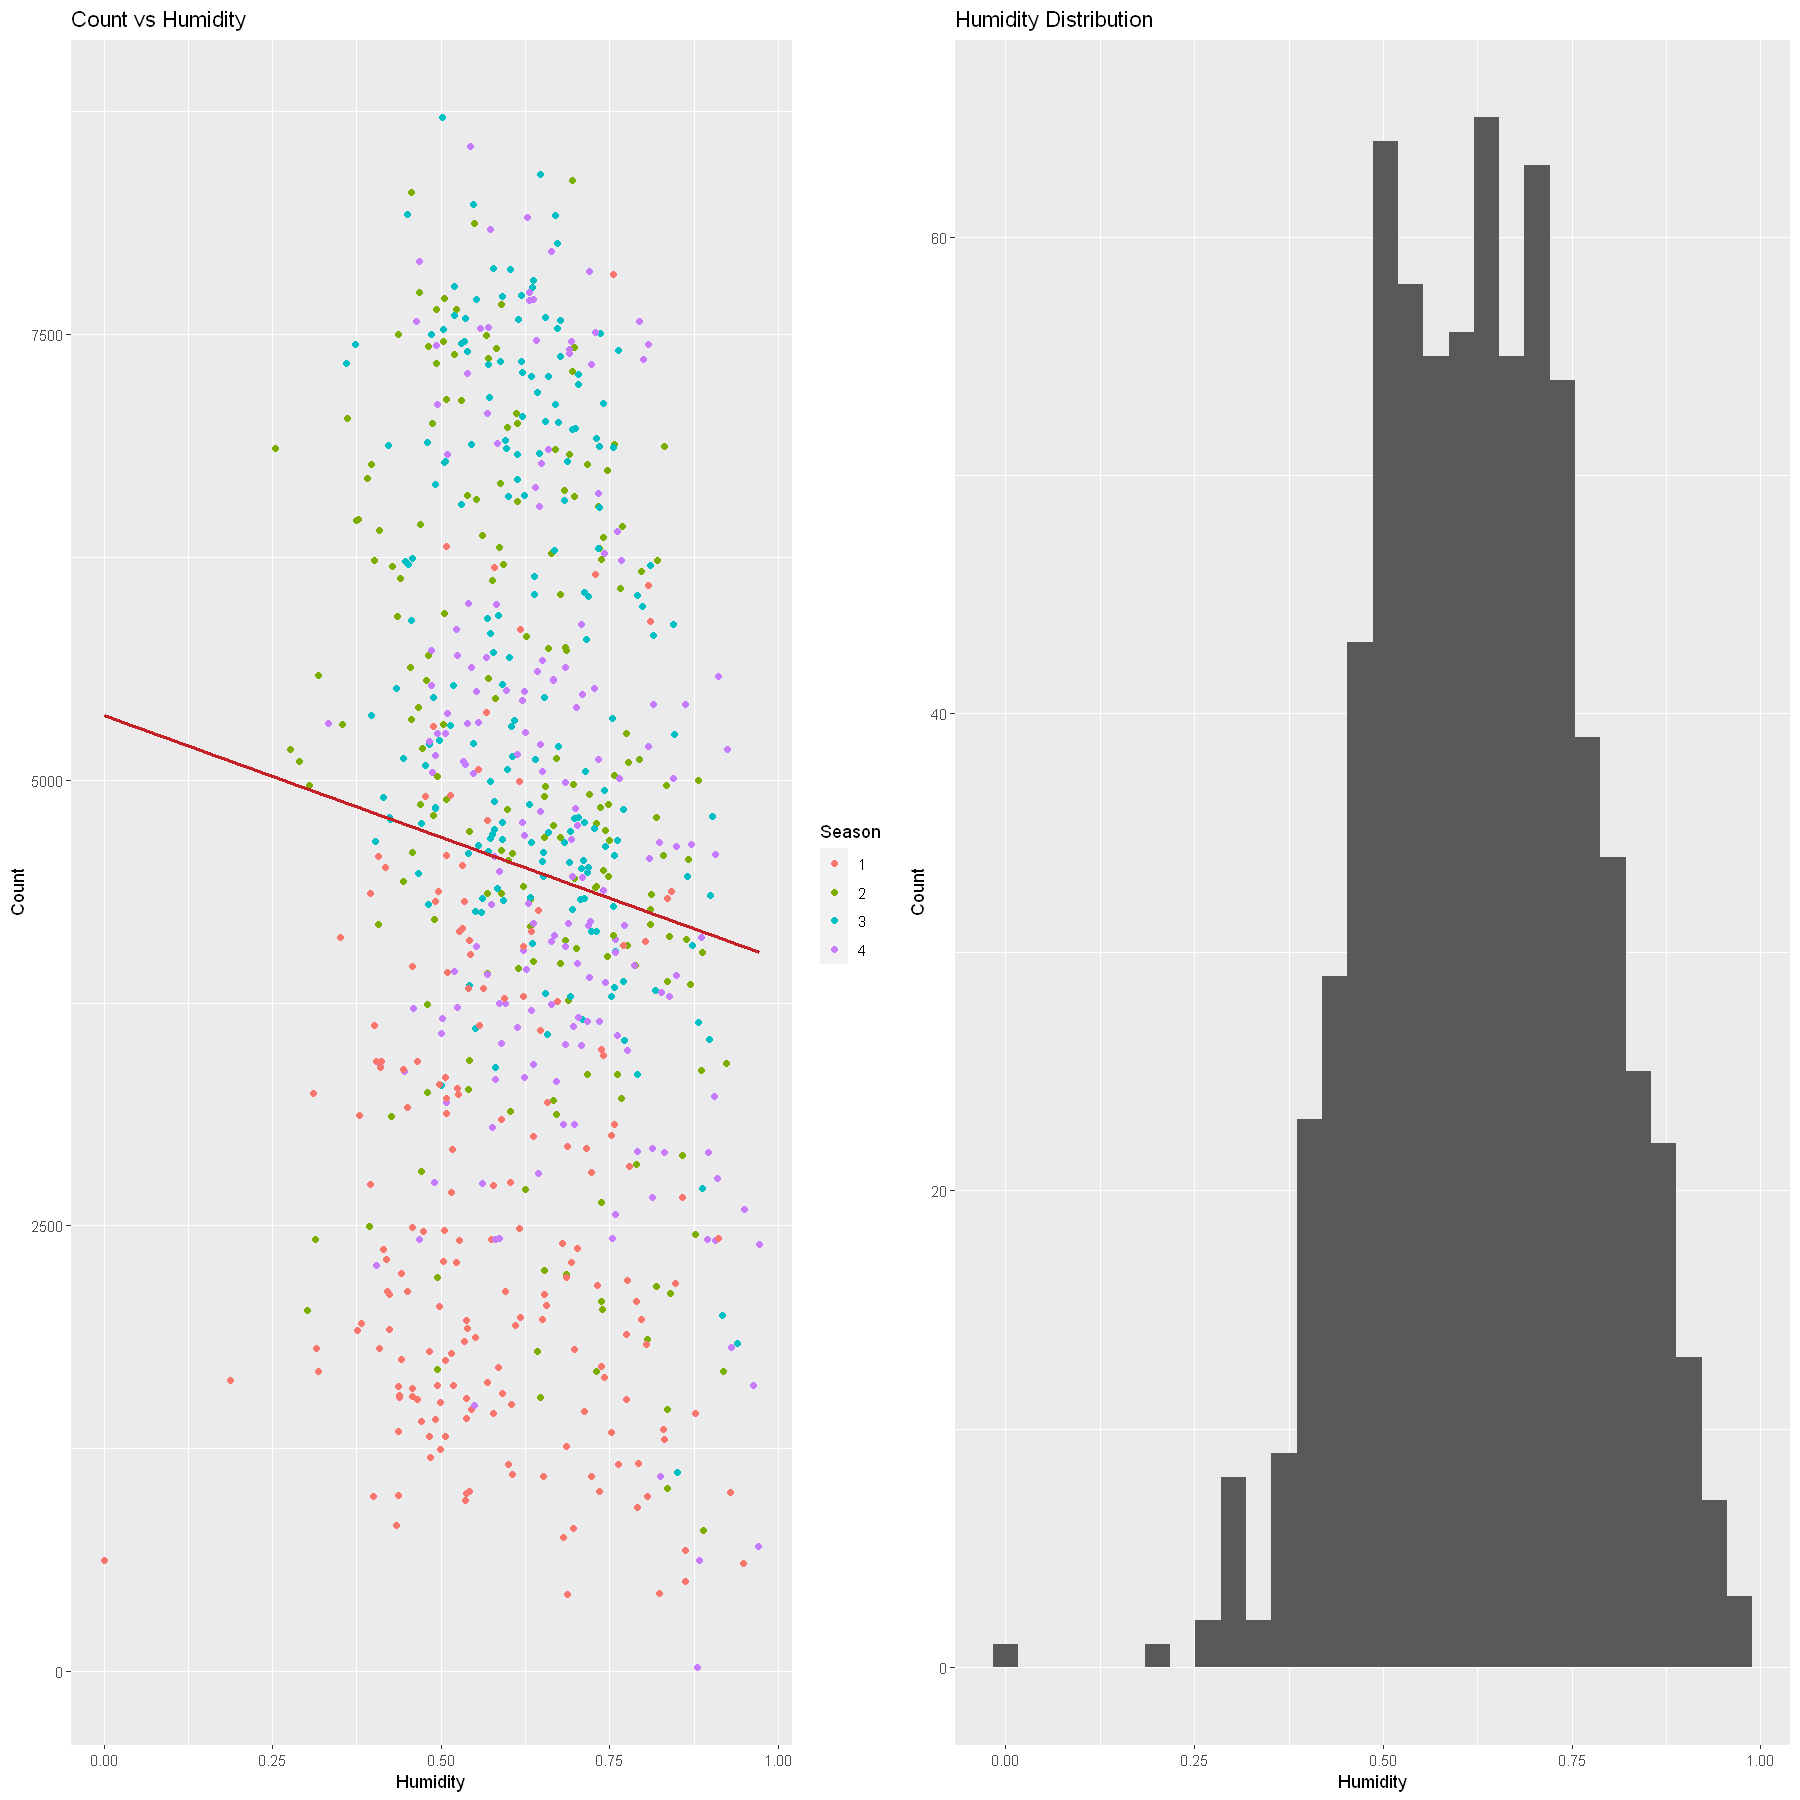

In [36]:
require(gridExtra)

# A scatter plot of Count vs Temperature; and the Temperature distribution plot next to it
plot1 <- ggplot(bike_sharing_day, aes(x = temp, y = cnt)) +
    geom_point(aes(color = factor(season))) +
    stat_smooth(method = "lm",
        col = "#C42126",
        se = FALSE,
        size = 1) +
    labs(x = "Temperature",
        y = "Count",
        color = "Season",
        title = "Count vs Temperature")
plot2 <- ggplot(bike_sharing_day, aes(temp)) +
    geom_histogram() +
    labs(title = "Temperature Distribution",
        y = "Count",
        x = "Temperature")

# A scatter plot of Count vs Windspeed; and the Windspeed distribution plot next to it
plot3 <- ggplot(bike_sharing_day, aes(x = windspeed, y = cnt)) +
    geom_point(aes(color = factor(season))) +
    stat_smooth(method = "lm",
        col = "#C42126",
        se = FALSE,
        size = 1) +
    labs(x = "Windspeed",
        y = "Count",
        color = "Season",
        title = "Count vs WindSpeed")
plot4 <- ggplot(bike_sharing_day, aes(windspeed)) +
    geom_histogram() +
    labs(title = "Windspeed Distribution",
        y = "Count",
        x = "Windspeed")

# A scatter plot of Count vs Humidity; and the Humidity distribution plot next to it
plot5 <- ggplot(bike_sharing_day, aes(x = hum, y = cnt)) +
    geom_point(aes(color = factor(season))) +
    stat_smooth(method = "lm",
        col = "#C42126",
        se = FALSE,
        size = 1) +
    labs(x = "Humidity",
        y = "Count",
        color = "Season",
        title = "Count vs Humidity")
plot6 <- ggplot(bike_sharing_day, aes(hum)) +
    geom_histogram() +
    labs(title = "Humidity Distribution",
        y = "Count",
        x = "Humidity")


# Arrange the plots into side-by-side pairs
grid.arrange(plot1, plot2, ncol=2)
grid.arrange(plot3, plot4, ncol=2)
grid.arrange(plot5, plot6, ncol=2)